In [30]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np


In [2]:
print_config()

MONAI version: 0.7.0+20.g87e2ecdc.dirty
Numpy version: 1.20.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: 87e2ecdcfc77c9f41d4fb10626d8c6e3e302be57

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.0.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: 2.1.0
gdown version: 3.11.1
TorchVision version: 0.8.2
tqdm version: 4.61.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
img_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Linear/"
ovr_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Annotations-Linear/"

all_images = sorted(glob(os.path.join(img_dir, '*.mha')))
all_labels = sorted(glob(os.path.join(ovr_dir, '*.interpolated-overlay.mha')))

num_images = len(all_images)
num_labels = len(all_labels)
print(num_images, num_labels)

train_images = all_images[:num_images-6]
train_labels = all_labels[:num_images-6]

val_images = all_images[num_images-6:]
val_labels = all_labels[num_images-6:]

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

58 58


In [4]:
#set_determinism(seed=0)

In [5]:
from monai.transforms.transform import Randomizable, Transform, MapTransform
from monai.transforms.inverse import InvertibleTransform
from monai.config.type_definitions import NdarrayOrTensor
from monai.config import IndexSelection, KeysCollection
from typing import Any, Callable, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union

class RandSpatialCropSlices(Randomizable, Transform):
    backend = SpatialCrop.backend

    def __init__(
        self,
        num_slices: int = 21,
        center_slice: int = -1,
    ) -> None:
        self.num_slices = num_slices
        self.center_slice = center_slice
        self._roi_start: Optional[Sequence[int]] = None
        self._roi_end: Optional[Sequence[int]] = None
    
    def __call__(self, img: NdarrayOrTensor) -> NdarrayOrTensor:
        """
        Apply the transform to `img`, assuming `img` is channel-first and
        slicing doesn't apply to the channel dim.
        """
        orig_size = img.shape[1:]
        boundary = self.num_slices//2
        
        self._roi_start = np.zeros((len(orig_size)), dtype=np.int32)
        buffer = 0
        if boundary*2 == self.num_slices:  # if even num_slices, add a buffer so last slice can be used
            buffer = 1
        
        if self.center_slice == -1:
            self.center_slice =  self.R.randint(boundary, img.shape[-1]-boundary+buffer)
        tlist = list(self._roi_start)
        tlist[-1] = self.center_slice - boundary
        self._roi_start = tuple(tlist)
        
        self._roi_end = orig_size
        tlist = list(self._roi_end)
        tlist[-1] = self._roi_start[-1] + self.num_slices
        self._roi_end = tuple(tlist)
        cropper = SpatialCrop(roi_start=self._roi_start, roi_end=self._roi_end)
        print(self._roi_start,self._roi_end)
        return cropper(img)
   

In [6]:
 
class RandSpatialCropSlicesd(MapTransform, InvertibleTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.SpatialCrop`.
    General purpose cropper to produce sub-volume region of interest (ROI).
    If a dimension of the expected ROI size is bigger than the input image size, will not crop that dimension.
    So the cropped result may be smaller than the expected ROI, and the cropped results of several images may
    not have exactly the same shape.
    It can support to crop ND spatial (channel-first) data.

    The cropped region can be parameterised in various ways:
        - a list of slices for each spatial dimension (allows for use of -ve indexing and `None`)
        - a spatial center and size
        - the start and end coordinates of the ROI
    """

    backend = RandSpatialCropSlices.backend

    def __init__(
        self,
        keys: KeysCollection,
        num_slices: int = 21,
        center_slice: int = -1,
        allow_missing_keys: bool = False,
    ) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            roi_center: voxel coordinates for center of the crop ROI.
            roi_size: size of the crop ROI, if a dimension of ROI size is bigger than image size,
                will not crop that dimension of the image.
            roi_start: voxel coordinates for start of the crop ROI.
            roi_end: voxel coordinates for end of the crop ROI, if a coordinate is out of image,
                use the end coordinate of image.
            roi_slices: list of slices for each of the spatial dimensions.
            allow_missing_keys: don't raise exception if key is missing.
        """
        super().__init__(keys, allow_missing_keys)
        self.cropper = RandSpatialCropSlices(num_slices)
        self.num_slices = num_slices
        self.center_slice = center_slice
        self._roi_start: Optional[Sequence[int]] = None
        self._roi_end: Optional[Sequence[int]] = None

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            orig_size = d[key].shape[1:]
            d[key] = self.cropper(d[key])
            self.push_transform(d, key, orig_size=orig_size)
        return d

    def inverse(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = deepcopy(dict(data))

        for key in self.key_iterator(d):
            transform = self.get_most_recent_transform(d, key)
            orig_size = transform[InverseKeys.ORIG_SIZE]
            pad_to_start = np.empty((len(orig_size)), dtype=np.int32)
            pad_to_end = np.empty((len(orig_size)), dtype=np.int32)
            
            boundary = self.num_slices//2
        
            self._roi_start = np.zeros((len(orig_size)), dtype=np.int32)
            buffer = 0
            if boundary*2 == self.num_slices:  # if even num_slices, add a buffer so last slice can be used
                buffer = 1
            if self.center_slice == -1:
                self.center_slice =  self.R.randint(boundary, img.shape[-1]-boundary+buffer)
            tlist = list(self._roi_start)
            tlist[-1] = self.center_slice - boundary
            self._roi_start = tuple(tlist)

            self._roi_end = orig_size
            tlist = list(self._roi_end)
            tlist[-1] = self._roi_start[-1] + self.num_slices
            self._roi_end = tuple(tlist)
        
            pad_to_start = self._roi_start
            pad_to_end = self._roi_end
            # interleave mins and maxes
            pad = list(chain(*zip(pad_to_start.tolist(), pad_to_end.tolist())))
            inverse_transform = BorderPad(pad)
            # Apply inverse transform
            d[key] = inverse_transform(d[key])
            # Remove the applied transform
            self.pop_transform(d, key)
            
        return d

In [19]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[144,144,60],
            mode=['trilinear', 'nearest']),
        RandSpatialCropSlicesd(num_slices=48,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.2, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[144,144,60],
            mode=['trilinear', 'nearest']),
        RandSpatialCropSlicesd(num_slices=48,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)
torch.Size([1, 1, 144, 144, 16])
torch.Size([144, 144, 16])
image shape: torch.Size([144, 144, 16]), label shape: torch.Size([144, 144, 16])


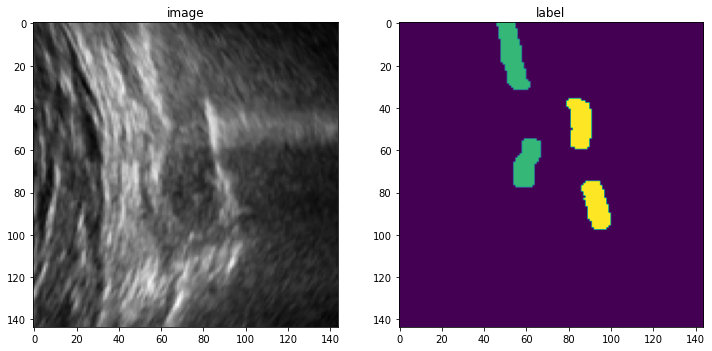

In [20]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [21]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=0)
#train_ds = Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)


val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
#val_ds = Dataset(data=val_files, transform=val_transforms)
    
val_loader = DataLoader(val_ds, batch_size=4, num_workers=0)

Loading dataset:   2%|▌                         | 1/52 [00:00<00:09,  5.17it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:   6%|█▌                        | 3/52 [00:00<00:07,  6.15it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  12%|███                       | 6/52 [00:00<00:07,  6.36it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  13%|███▌                      | 7/52 [00:01<00:07,  6.09it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  17%|████▌                     | 9/52 [00:01<00:06,  6.21it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  23%|█████▊                   | 12/52 [00:01<00:06,  6.43it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  27%|██████▋                  | 14/52 [00:02<00:05,  6.41it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  31%|███████▋                 | 16/52 [00:02<00:05,  6.44it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  35%|████████▋                | 18/52 [00:02<00:05,  6.52it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  38%|█████████▌               | 20/52 [00:03<00:04,  6.49it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  42%|██████████▌              | 22/52 [00:03<00:04,  6.02it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  46%|███████████▌             | 24/52 [00:03<00:04,  6.33it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  48%|████████████             | 25/52 [00:03<00:04,  6.35it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  52%|████████████▉            | 27/52 [00:04<00:04,  5.76it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  58%|██████████████▍          | 30/52 [00:04<00:03,  5.75it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  62%|███████████████▍         | 32/52 [00:05<00:03,  6.13it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  65%|████████████████▎        | 34/52 [00:05<00:02,  6.04it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  69%|█████████████████▎       | 36/52 [00:05<00:02,  6.22it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  73%|██████████████████▎      | 38/52 [00:06<00:01,  7.01it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  77%|███████████████████▏     | 40/52 [00:06<00:01,  6.90it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  81%|████████████████████▏    | 42/52 [00:06<00:01,  6.72it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  83%|████████████████████▋    | 43/52 [00:06<00:01,  6.50it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  87%|█████████████████████▋   | 45/52 [00:07<00:01,  6.25it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  92%|███████████████████████  | 48/52 [00:07<00:00,  6.30it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset:  96%|████████████████████████ | 50/52 [00:08<00:00,  6.22it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)


Loading dataset: 100%|█████████████████████████| 52/52 [00:08<00:00,  6.23it/s]

(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)
(0, 0, 29) (144, 144, 45)



Loading dataset:  33%|█████████                  | 2/6 [00:00<00:00,  6.56it/s]

(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)


Loading dataset:  67%|██████████████████         | 4/6 [00:00<00:00,  6.38it/s]

(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)


Loading dataset: 100%|███████████████████████████| 6/6 [00:00<00:00,  6.39it/s]

(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)
(0, 0, 4) (144, 144, 20)


## Create Model, Loss, Optimizer

In [22]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [25]:
max_epochs = 2000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=4)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=4)])

root_dir = "."

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        print("Step =", step)
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (144, 144, 16)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
Step = 0
1/13, train_loss: 0.8196
Step = 1
2/13, train_loss: 0.8271
Step = 2
3/13, train_loss: 0.8155
Step = 3
4/13, train_loss: 0.8184
Step = 4
5/13, train_loss: 0.8151
Step = 5
6/13, train_loss: 0.8058
Step = 6
7/13, train_loss: 0.8180
Step = 7
8/13, train_loss: 0.8091
Step = 8
9/13, train_loss: 0.8208
Step = 9
10/13, train_loss: 0.8106
Step = 10
11/13, train_loss: 0.8108
Step = 11
12/13, train_loss: 0.8007
Step = 12
13/13, train_loss: 0.8173
epoch 1 average loss: 0.8145
----------
epoch 2/600
Step = 0
1/13, train_loss: 0.8166
Step = 1
2/13, train_loss: 0.8124
Step = 2
3/13, train_loss: 0.8066
Step = 3
4/13, train_loss: 0.8100
Step = 4
5/13, train_loss: 0.7921
Step = 5
6/13, train_loss: 0.8094
Step = 6
7/13, train_loss: 0.8136
Step = 7
8/13, train_loss: 0.8135
Step = 8
9/13, train_loss: 0.8151
Step = 9
10/13, train_loss: 0.8068
Step = 10
11/13, train_loss: 0.7980
Step = 11
12/13, train_loss: 0.7977
Step = 12
13/13, train_loss: 0.7966
epoch 2 average loss: 0.806

2/13, train_loss: 0.7434
Step = 2
3/13, train_loss: 0.7225
Step = 3
4/13, train_loss: 0.7413
Step = 4
5/13, train_loss: 0.7460
Step = 5
6/13, train_loss: 0.7240
Step = 6
7/13, train_loss: 0.7352
Step = 7
8/13, train_loss: 0.7231
Step = 8
9/13, train_loss: 0.7295
Step = 9
10/13, train_loss: 0.7257
Step = 10
11/13, train_loss: 0.7170
Step = 11
12/13, train_loss: 0.7161
Step = 12
13/13, train_loss: 0.7455
epoch 16 average loss: 0.7324
saved new best metric model
current epoch: 16 current mean dice: 0.1302
best mean dice: 0.1302 at epoch: 16
----------
epoch 17/600
Step = 0
1/13, train_loss: 0.7334
Step = 1
2/13, train_loss: 0.7395
Step = 2
3/13, train_loss: 0.7282
Step = 3
4/13, train_loss: 0.7422
Step = 4
5/13, train_loss: 0.7091
Step = 5
6/13, train_loss: 0.7369
Step = 6
7/13, train_loss: 0.7366
Step = 7
8/13, train_loss: 0.7526
Step = 8
9/13, train_loss: 0.7507
Step = 9
10/13, train_loss: 0.7037
Step = 10
11/13, train_loss: 0.7157
Step = 11
12/13, train_loss: 0.7192
Step = 12
13/13, tr

1/13, train_loss: 0.7146
Step = 1
2/13, train_loss: 0.6787
Step = 2
3/13, train_loss: 0.6968
Step = 3
4/13, train_loss: 0.6762
Step = 4
5/13, train_loss: 0.6865
Step = 5
6/13, train_loss: 0.6765
Step = 6
7/13, train_loss: 0.6570
Step = 7
8/13, train_loss: 0.6838
Step = 8
9/13, train_loss: 0.6716
Step = 9
10/13, train_loss: 0.7146
Step = 10
11/13, train_loss: 0.6760
Step = 11
12/13, train_loss: 0.6773
Step = 12
13/13, train_loss: 0.6790
epoch 31 average loss: 0.6837
----------
epoch 32/600
Step = 0
1/13, train_loss: 0.6966
Step = 1
2/13, train_loss: 0.6978
Step = 2
3/13, train_loss: 0.6816
Step = 3
4/13, train_loss: 0.6779
Step = 4
5/13, train_loss: 0.6692
Step = 5
6/13, train_loss: 0.6666
Step = 6
7/13, train_loss: 0.6945
Step = 7
8/13, train_loss: 0.6683
Step = 8
9/13, train_loss: 0.6740
Step = 9
10/13, train_loss: 0.6957
Step = 10
11/13, train_loss: 0.6676
Step = 11
12/13, train_loss: 0.7128
Step = 12
13/13, train_loss: 0.6622
epoch 32 average loss: 0.6819
current epoch: 32 current m

5/13, train_loss: 0.6364
Step = 5
6/13, train_loss: 0.6554
Step = 6
7/13, train_loss: 0.6089
Step = 7
8/13, train_loss: 0.6594
Step = 8
9/13, train_loss: 0.6749
Step = 9
10/13, train_loss: 0.6426
Step = 10
11/13, train_loss: 0.6629
Step = 11
12/13, train_loss: 0.6313
Step = 12
13/13, train_loss: 0.6523
epoch 46 average loss: 0.6471
saved new best metric model
current epoch: 46 current mean dice: 0.2021
best mean dice: 0.2021 at epoch: 46
----------
epoch 47/600
Step = 0
1/13, train_loss: 0.6377
Step = 1
2/13, train_loss: 0.6451
Step = 2
3/13, train_loss: 0.6384
Step = 3
4/13, train_loss: 0.6360
Step = 4
5/13, train_loss: 0.6523
Step = 5
6/13, train_loss: 0.6711
Step = 6
7/13, train_loss: 0.6233
Step = 7
8/13, train_loss: 0.6926
Step = 8
9/13, train_loss: 0.6524
Step = 9
10/13, train_loss: 0.6577
Step = 10
11/13, train_loss: 0.6393
Step = 11
12/13, train_loss: 0.6313
Step = 12
13/13, train_loss: 0.6128
epoch 47 average loss: 0.6454
----------
epoch 48/600
Step = 0
1/13, train_loss: 0.63

Step = 2
3/13, train_loss: 0.6096
Step = 3
4/13, train_loss: 0.6350
Step = 4
5/13, train_loss: 0.6246
Step = 5
6/13, train_loss: 0.6161
Step = 6
7/13, train_loss: 0.6510
Step = 7
8/13, train_loss: 0.6336
Step = 8
9/13, train_loss: 0.6307
Step = 9
10/13, train_loss: 0.6177
Step = 10
11/13, train_loss: 0.6353
Step = 11
12/13, train_loss: 0.6466
Step = 12
13/13, train_loss: 0.5874
epoch 61 average loss: 0.6231
----------
epoch 62/600
Step = 0
1/13, train_loss: 0.6023
Step = 1
2/13, train_loss: 0.5829
Step = 2
3/13, train_loss: 0.6290
Step = 3
4/13, train_loss: 0.6401
Step = 4
5/13, train_loss: 0.6344
Step = 5
6/13, train_loss: 0.6602
Step = 6
7/13, train_loss: 0.6170
Step = 7
8/13, train_loss: 0.6459
Step = 8
9/13, train_loss: 0.6469
Step = 9
10/13, train_loss: 0.6226
Step = 10
11/13, train_loss: 0.6019
Step = 11
12/13, train_loss: 0.5765
Step = 12
13/13, train_loss: 0.6264
epoch 62 average loss: 0.6220
current epoch: 62 current mean dice: 0.2174
best mean dice: 0.2313 at epoch: 60
------

Step = 5
6/13, train_loss: 0.6130
Step = 6
7/13, train_loss: 0.6260
Step = 7
8/13, train_loss: 0.6143
Step = 8
9/13, train_loss: 0.5873
Step = 9
10/13, train_loss: 0.6003
Step = 10
11/13, train_loss: 0.6314
Step = 11
12/13, train_loss: 0.6370
Step = 12
13/13, train_loss: 0.5735
epoch 76 average loss: 0.6108
current epoch: 76 current mean dice: 0.1913
best mean dice: 0.2313 at epoch: 60
----------
epoch 77/600
Step = 0
1/13, train_loss: 0.6519
Step = 1
2/13, train_loss: 0.6248
Step = 2
3/13, train_loss: 0.6138
Step = 3
4/13, train_loss: 0.6069
Step = 4
5/13, train_loss: 0.6564
Step = 5
6/13, train_loss: 0.6079
Step = 6
7/13, train_loss: 0.6046
Step = 7
8/13, train_loss: 0.5959
Step = 8
9/13, train_loss: 0.6445
Step = 9
10/13, train_loss: 0.5621
Step = 10
11/13, train_loss: 0.5947
Step = 11
12/13, train_loss: 0.5975
Step = 12
13/13, train_loss: 0.5920
epoch 77 average loss: 0.6118
----------
epoch 78/600
Step = 0
1/13, train_loss: 0.5852
Step = 1
2/13, train_loss: 0.5870
Step = 2
3/13, t

6/13, train_loss: 0.5878
Step = 6
7/13, train_loss: 0.5823
Step = 7
8/13, train_loss: 0.5814
Step = 8
9/13, train_loss: 0.6469
Step = 9
10/13, train_loss: 0.5882
Step = 10
11/13, train_loss: 0.5929
Step = 11
12/13, train_loss: 0.6819
Step = 12
13/13, train_loss: 0.5709
epoch 91 average loss: 0.6035
----------
epoch 92/600
Step = 0
1/13, train_loss: 0.5780
Step = 1
2/13, train_loss: 0.6229
Step = 2
3/13, train_loss: 0.5639
Step = 3
4/13, train_loss: 0.6307
Step = 4
5/13, train_loss: 0.5541
Step = 5
6/13, train_loss: 0.6125
Step = 6
7/13, train_loss: 0.5850
Step = 7
8/13, train_loss: 0.5968
Step = 8
9/13, train_loss: 0.5750
Step = 9
10/13, train_loss: 0.6183
Step = 10
11/13, train_loss: 0.6221
Step = 11
12/13, train_loss: 0.6295
Step = 12
13/13, train_loss: 0.5723
epoch 92 average loss: 0.5970
current epoch: 92 current mean dice: 0.2402
best mean dice: 0.2429 at epoch: 88
----------
epoch 93/600
Step = 0
1/13, train_loss: 0.5882
Step = 1
2/13, train_loss: 0.5855
Step = 2
3/13, train_loss

8/13, train_loss: 0.5574
Step = 8
9/13, train_loss: 0.5916
Step = 9
10/13, train_loss: 0.5974
Step = 10
11/13, train_loss: 0.5488
Step = 11
12/13, train_loss: 0.5956
Step = 12
13/13, train_loss: 0.6082
epoch 106 average loss: 0.5844
current epoch: 106 current mean dice: 0.2271
best mean dice: 0.2491 at epoch: 96
----------
epoch 107/600
Step = 0
1/13, train_loss: 0.5844
Step = 1
2/13, train_loss: 0.5736
Step = 2
3/13, train_loss: 0.5684
Step = 3
4/13, train_loss: 0.5523
Step = 4
5/13, train_loss: 0.6175
Step = 5
6/13, train_loss: 0.6124
Step = 6
7/13, train_loss: 0.5944
Step = 7
8/13, train_loss: 0.5555
Step = 8
9/13, train_loss: 0.5968
Step = 9
10/13, train_loss: 0.6194
Step = 10
11/13, train_loss: 0.6127
Step = 11
12/13, train_loss: 0.5955
Step = 12
13/13, train_loss: 0.5437
epoch 107 average loss: 0.5867
----------
epoch 108/600
Step = 0
1/13, train_loss: 0.6448
Step = 1
2/13, train_loss: 0.5756
Step = 2
3/13, train_loss: 0.5662
Step = 3
4/13, train_loss: 0.5470
Step = 4
5/13, train

Step = 7
8/13, train_loss: 0.5202
Step = 8
9/13, train_loss: 0.5390
Step = 9
10/13, train_loss: 0.5818
Step = 10
11/13, train_loss: 0.6305
Step = 11
12/13, train_loss: 0.6038
Step = 12
13/13, train_loss: 0.5941
epoch 121 average loss: 0.5818
----------
epoch 122/600
Step = 0
1/13, train_loss: 0.6163
Step = 1
2/13, train_loss: 0.5782
Step = 2
3/13, train_loss: 0.6140
Step = 3
4/13, train_loss: 0.5730
Step = 4
5/13, train_loss: 0.6066
Step = 5
6/13, train_loss: 0.6134
Step = 6
7/13, train_loss: 0.5848
Step = 7
8/13, train_loss: 0.5669
Step = 8
9/13, train_loss: 0.5694
Step = 9
10/13, train_loss: 0.5746
Step = 10
11/13, train_loss: 0.5993
Step = 11
12/13, train_loss: 0.5529
Step = 12
13/13, train_loss: 0.5669
epoch 122 average loss: 0.5859
current epoch: 122 current mean dice: 0.2494
best mean dice: 0.2651 at epoch: 114
----------
epoch 123/600
Step = 0
1/13, train_loss: 0.5668
Step = 1
2/13, train_loss: 0.5700
Step = 2
3/13, train_loss: 0.5675
Step = 3
4/13, train_loss: 0.5447
Step = 4
5

9/13, train_loss: 0.6149
Step = 9
10/13, train_loss: 0.6368
Step = 10
11/13, train_loss: 0.5307
Step = 11
12/13, train_loss: 0.6005
Step = 12
13/13, train_loss: 0.5595
epoch 136 average loss: 0.5720
current epoch: 136 current mean dice: 0.2541
best mean dice: 0.2820 at epoch: 124
----------
epoch 137/600
Step = 0
1/13, train_loss: 0.5703
Step = 1
2/13, train_loss: 0.5761
Step = 2
3/13, train_loss: 0.5967
Step = 3
4/13, train_loss: 0.5615
Step = 4
5/13, train_loss: 0.5614
Step = 5
6/13, train_loss: 0.5647
Step = 6
7/13, train_loss: 0.5477
Step = 7
8/13, train_loss: 0.6475
Step = 8
9/13, train_loss: 0.5259
Step = 9
10/13, train_loss: 0.5512
Step = 10
11/13, train_loss: 0.6001
Step = 11
12/13, train_loss: 0.5814
Step = 12
13/13, train_loss: 0.5247
epoch 137 average loss: 0.5699
----------
epoch 138/600
Step = 0
1/13, train_loss: 0.6128
Step = 1
2/13, train_loss: 0.6108
Step = 2
3/13, train_loss: 0.5778
Step = 3
4/13, train_loss: 0.5987
Step = 4
5/13, train_loss: 0.5608
Step = 5
6/13, trai

Step = 8
9/13, train_loss: 0.5678
Step = 9
10/13, train_loss: 0.5988
Step = 10
11/13, train_loss: 0.5600
Step = 11
12/13, train_loss: 0.5713
Step = 12
13/13, train_loss: 0.5587
epoch 151 average loss: 0.5713
----------
epoch 152/600
Step = 0
1/13, train_loss: 0.6339
Step = 1
2/13, train_loss: 0.6047
Step = 2
3/13, train_loss: 0.5749
Step = 3
4/13, train_loss: 0.5807
Step = 4
5/13, train_loss: 0.5839
Step = 5
6/13, train_loss: 0.5067
Step = 6
7/13, train_loss: 0.5538
Step = 7
8/13, train_loss: 0.5235
Step = 8
9/13, train_loss: 0.5708
Step = 9
10/13, train_loss: 0.5685
Step = 10
11/13, train_loss: 0.6102
Step = 11
12/13, train_loss: 0.5448
Step = 12
13/13, train_loss: 0.5349
epoch 152 average loss: 0.5686
current epoch: 152 current mean dice: 0.2129
best mean dice: 0.2914 at epoch: 142
----------
epoch 153/600
Step = 0
1/13, train_loss: 0.5952
Step = 1
2/13, train_loss: 0.6166
Step = 2
3/13, train_loss: 0.5551
Step = 3
4/13, train_loss: 0.5467
Step = 4
5/13, train_loss: 0.5879
Step = 5
6

12/13, train_loss: 0.6244
Step = 12
13/13, train_loss: 0.5972
epoch 166 average loss: 0.5623
current epoch: 166 current mean dice: 0.2031
best mean dice: 0.2914 at epoch: 142
----------
epoch 167/600
Step = 0
1/13, train_loss: 0.5234
Step = 1
2/13, train_loss: 0.5452
Step = 2
3/13, train_loss: 0.5906
Step = 3
4/13, train_loss: 0.5413
Step = 4
5/13, train_loss: 0.5540
Step = 5
6/13, train_loss: 0.5571
Step = 6
7/13, train_loss: 0.5570
Step = 7
8/13, train_loss: 0.5589
Step = 8
9/13, train_loss: 0.5447
Step = 9
10/13, train_loss: 0.5887
Step = 10
11/13, train_loss: 0.6072
Step = 11
12/13, train_loss: 0.5889
Step = 12
13/13, train_loss: 0.6133
epoch 167 average loss: 0.5669
----------
epoch 168/600
Step = 0
1/13, train_loss: 0.5777
Step = 1
2/13, train_loss: 0.5777
Step = 2
3/13, train_loss: 0.5938
Step = 3
4/13, train_loss: 0.5624
Step = 4
5/13, train_loss: 0.5589
Step = 5
6/13, train_loss: 0.5579
Step = 6
7/13, train_loss: 0.5286
Step = 7
8/13, train_loss: 0.5903
Step = 8
9/13, train_lo

11/13, train_loss: 0.6215
Step = 11
12/13, train_loss: 0.5651
Step = 12
13/13, train_loss: 0.5753
epoch 181 average loss: 0.5619
----------
epoch 182/600
Step = 0
1/13, train_loss: 0.5781
Step = 1
2/13, train_loss: 0.6162
Step = 2
3/13, train_loss: 0.5665
Step = 3
4/13, train_loss: 0.5882
Step = 4
5/13, train_loss: 0.6330
Step = 5
6/13, train_loss: 0.5735
Step = 6
7/13, train_loss: 0.5538
Step = 7
8/13, train_loss: 0.5310
Step = 8
9/13, train_loss: 0.5379
Step = 9
10/13, train_loss: 0.5304
Step = 10
11/13, train_loss: 0.5227
Step = 11
12/13, train_loss: 0.5206
Step = 12
13/13, train_loss: 0.5325
epoch 182 average loss: 0.5603
current epoch: 182 current mean dice: 0.2767
best mean dice: 0.3175 at epoch: 178
----------
epoch 183/600
Step = 0
1/13, train_loss: 0.5645
Step = 1
2/13, train_loss: 0.5919
Step = 2
3/13, train_loss: 0.5203
Step = 3
4/13, train_loss: 0.5563
Step = 4
5/13, train_loss: 0.6004
Step = 5
6/13, train_loss: 0.5429
Step = 6
7/13, train_loss: 0.5376
Step = 7
8/13, train_

current epoch: 196 current mean dice: 0.2257
best mean dice: 0.3175 at epoch: 178
----------
epoch 197/600
Step = 0
1/13, train_loss: 0.5448
Step = 1
2/13, train_loss: 0.5359
Step = 2
3/13, train_loss: 0.6106
Step = 3
4/13, train_loss: 0.5796
Step = 4
5/13, train_loss: 0.5213
Step = 5
6/13, train_loss: 0.5554
Step = 6
7/13, train_loss: 0.4859
Step = 7
8/13, train_loss: 0.5966
Step = 8
9/13, train_loss: 0.5087
Step = 9
10/13, train_loss: 0.5973
Step = 10
11/13, train_loss: 0.6037
Step = 11
12/13, train_loss: 0.5390
Step = 12
13/13, train_loss: 0.5816
epoch 197 average loss: 0.5585
----------
epoch 198/600
Step = 0
1/13, train_loss: 0.5760
Step = 1
2/13, train_loss: 0.6168
Step = 2
3/13, train_loss: 0.5620
Step = 3
4/13, train_loss: 0.5242
Step = 4
5/13, train_loss: 0.6076
Step = 5
6/13, train_loss: 0.5476
Step = 6
7/13, train_loss: 0.5467
Step = 7
8/13, train_loss: 0.5044
Step = 8
9/13, train_loss: 0.5121
Step = 9
10/13, train_loss: 0.5792
Step = 10
11/13, train_loss: 0.5364
Step = 11
1

1/13, train_loss: 0.5081
Step = 1
2/13, train_loss: 0.5181
Step = 2
3/13, train_loss: 0.5830
Step = 3
4/13, train_loss: 0.5222
Step = 4
5/13, train_loss: 0.5964
Step = 5
6/13, train_loss: 0.5704
Step = 6
7/13, train_loss: 0.6236
Step = 7
8/13, train_loss: 0.6275
Step = 8
9/13, train_loss: 0.4795
Step = 9
10/13, train_loss: 0.5782
Step = 10
11/13, train_loss: 0.5941
Step = 11
12/13, train_loss: 0.5123
Step = 12
13/13, train_loss: 0.5764
epoch 212 average loss: 0.5608
current epoch: 212 current mean dice: 0.2512
best mean dice: 0.3318 at epoch: 210
----------
epoch 213/600
Step = 0
1/13, train_loss: 0.5253
Step = 1
2/13, train_loss: 0.4920
Step = 2
3/13, train_loss: 0.6345
Step = 3
4/13, train_loss: 0.5981
Step = 4
5/13, train_loss: 0.5521
Step = 5
6/13, train_loss: 0.5799
Step = 6
7/13, train_loss: 0.5425
Step = 7
8/13, train_loss: 0.5674
Step = 8
9/13, train_loss: 0.5023
Step = 9
10/13, train_loss: 0.5494
Step = 10
11/13, train_loss: 0.5573
Step = 11
12/13, train_loss: 0.5675
Step = 12

1/13, train_loss: 0.5182
Step = 1
2/13, train_loss: 0.5596
Step = 2
3/13, train_loss: 0.5693
Step = 3
4/13, train_loss: 0.5619
Step = 4
5/13, train_loss: 0.5495
Step = 5
6/13, train_loss: 0.4912
Step = 6
7/13, train_loss: 0.5893
Step = 7
8/13, train_loss: 0.5132
Step = 8
9/13, train_loss: 0.5654
Step = 9
10/13, train_loss: 0.5417
Step = 10
11/13, train_loss: 0.5471
Step = 11
12/13, train_loss: 0.5461
Step = 12
13/13, train_loss: 0.5581
epoch 227 average loss: 0.5470
----------
epoch 228/600
Step = 0
1/13, train_loss: 0.5416
Step = 1
2/13, train_loss: 0.5513
Step = 2
3/13, train_loss: 0.5441
Step = 3
4/13, train_loss: 0.5636
Step = 4
5/13, train_loss: 0.5565
Step = 5
6/13, train_loss: 0.6067
Step = 6
7/13, train_loss: 0.5700
Step = 7
8/13, train_loss: 0.6061
Step = 8
9/13, train_loss: 0.5374
Step = 9
10/13, train_loss: 0.5112
Step = 10
11/13, train_loss: 0.5727
Step = 11
12/13, train_loss: 0.5626
Step = 12
13/13, train_loss: 0.4830
epoch 228 average loss: 0.5544
current epoch: 228 curre

4/13, train_loss: 0.5014
Step = 4
5/13, train_loss: 0.5728
Step = 5
6/13, train_loss: 0.4961
Step = 6
7/13, train_loss: 0.5670
Step = 7
8/13, train_loss: 0.5306
Step = 8
9/13, train_loss: 0.6056
Step = 9
10/13, train_loss: 0.5118
Step = 10
11/13, train_loss: 0.5642
Step = 11
12/13, train_loss: 0.5726
Step = 12
13/13, train_loss: 0.5102
epoch 242 average loss: 0.5446
current epoch: 242 current mean dice: 0.3124
best mean dice: 0.3318 at epoch: 210
----------
epoch 243/600
Step = 0
1/13, train_loss: 0.5181
Step = 1
2/13, train_loss: 0.5580
Step = 2
3/13, train_loss: 0.5483
Step = 3
4/13, train_loss: 0.5297
Step = 4
5/13, train_loss: 0.5062
Step = 5
6/13, train_loss: 0.5879
Step = 6
7/13, train_loss: 0.4973
Step = 7
8/13, train_loss: 0.5557
Step = 8
9/13, train_loss: 0.5969
Step = 9
10/13, train_loss: 0.4875
Step = 10
11/13, train_loss: 0.5092
Step = 11
12/13, train_loss: 0.5492
Step = 12
13/13, train_loss: 0.5739
epoch 243 average loss: 0.5398
----------
epoch 244/600
Step = 0
1/13, trai

3/13, train_loss: 0.5837
Step = 3
4/13, train_loss: 0.5447
Step = 4
5/13, train_loss: 0.5242
Step = 5
6/13, train_loss: 0.5313
Step = 6
7/13, train_loss: 0.5225
Step = 7
8/13, train_loss: 0.5059
Step = 8
9/13, train_loss: 0.5143
Step = 9
10/13, train_loss: 0.4933
Step = 10
11/13, train_loss: 0.5748
Step = 11
12/13, train_loss: 0.5423
Step = 12
13/13, train_loss: 0.5943
epoch 257 average loss: 0.5379
----------
epoch 258/600
Step = 0
1/13, train_loss: 0.5861
Step = 1
2/13, train_loss: 0.4859
Step = 2
3/13, train_loss: 0.5525
Step = 3
4/13, train_loss: 0.4888
Step = 4
5/13, train_loss: 0.5319
Step = 5
6/13, train_loss: 0.5336
Step = 6
7/13, train_loss: 0.5381
Step = 7
8/13, train_loss: 0.5138
Step = 8
9/13, train_loss: 0.5776
Step = 9
10/13, train_loss: 0.5301
Step = 10
11/13, train_loss: 0.4941
Step = 11
12/13, train_loss: 0.5835
Step = 12
13/13, train_loss: 0.5955
epoch 258 average loss: 0.5393
current epoch: 258 current mean dice: 0.1809
best mean dice: 0.3318 at epoch: 210
----------

5/13, train_loss: 0.5522
Step = 5
6/13, train_loss: 0.5044
Step = 6
7/13, train_loss: 0.6196
Step = 7
8/13, train_loss: 0.4982
Step = 8
9/13, train_loss: 0.5437
Step = 9
10/13, train_loss: 0.5066
Step = 10
11/13, train_loss: 0.5444
Step = 11
12/13, train_loss: 0.4963
Step = 12
13/13, train_loss: 0.6211
epoch 272 average loss: 0.5336
current epoch: 272 current mean dice: 0.3275
best mean dice: 0.3318 at epoch: 210
----------
epoch 273/600
Step = 0
1/13, train_loss: 0.5856
Step = 1
2/13, train_loss: 0.5346
Step = 2
3/13, train_loss: 0.5249
Step = 3
4/13, train_loss: 0.5236
Step = 4
5/13, train_loss: 0.4885
Step = 5
6/13, train_loss: 0.5079
Step = 6
7/13, train_loss: 0.5352
Step = 7
8/13, train_loss: 0.5390
Step = 8
9/13, train_loss: 0.5318
Step = 9
10/13, train_loss: 0.5521
Step = 10
11/13, train_loss: 0.5086
Step = 11
12/13, train_loss: 0.5585
Step = 12
13/13, train_loss: 0.5972
epoch 273 average loss: 0.5375
----------
epoch 274/600
Step = 0
1/13, train_loss: 0.5010
Step = 1
2/13, trai

Step = 4
5/13, train_loss: 0.5286
Step = 5
6/13, train_loss: 0.5036
Step = 6
7/13, train_loss: 0.5481
Step = 7
8/13, train_loss: 0.5848
Step = 8
9/13, train_loss: 0.4953
Step = 9
10/13, train_loss: 0.5155
Step = 10
11/13, train_loss: 0.4807
Step = 11
12/13, train_loss: 0.5106
Step = 12
13/13, train_loss: 0.5301
epoch 287 average loss: 0.5305
----------
epoch 288/600
Step = 0
1/13, train_loss: 0.4972
Step = 1
2/13, train_loss: 0.5549
Step = 2
3/13, train_loss: 0.5240
Step = 3
4/13, train_loss: 0.5833
Step = 4
5/13, train_loss: 0.5548
Step = 5
6/13, train_loss: 0.5428
Step = 6
7/13, train_loss: 0.5786
Step = 7
8/13, train_loss: 0.5205
Step = 8
9/13, train_loss: 0.5389
Step = 9
10/13, train_loss: 0.5109
Step = 10
11/13, train_loss: 0.5667
Step = 11
12/13, train_loss: 0.5384
Step = 12
13/13, train_loss: 0.4472
epoch 288 average loss: 0.5353
current epoch: 288 current mean dice: 0.3247
best mean dice: 0.3567 at epoch: 280
----------
epoch 289/600
Step = 0
1/13, train_loss: 0.4691
Step = 1
2

Step = 6
7/13, train_loss: 0.5677
Step = 7
8/13, train_loss: 0.5254
Step = 8
9/13, train_loss: 0.5304
Step = 9
10/13, train_loss: 0.5073
Step = 10
11/13, train_loss: 0.5305
Step = 11
12/13, train_loss: 0.5443
Step = 12
13/13, train_loss: 0.5618
epoch 302 average loss: 0.5289
current epoch: 302 current mean dice: 0.2521
best mean dice: 0.3567 at epoch: 280
----------
epoch 303/600
Step = 0
1/13, train_loss: 0.5536
Step = 1
2/13, train_loss: 0.4911
Step = 2
3/13, train_loss: 0.4681
Step = 3
4/13, train_loss: 0.4540
Step = 4
5/13, train_loss: 0.5370
Step = 5
6/13, train_loss: 0.5787
Step = 6
7/13, train_loss: 0.5380
Step = 7
8/13, train_loss: 0.6326
Step = 8
9/13, train_loss: 0.5468
Step = 9
10/13, train_loss: 0.5101
Step = 10
11/13, train_loss: 0.5133
Step = 11
12/13, train_loss: 0.5503
Step = 12
13/13, train_loss: 0.5399
epoch 303 average loss: 0.5318
----------
epoch 304/600
Step = 0
1/13, train_loss: 0.4792
Step = 1
2/13, train_loss: 0.4982
Step = 2
3/13, train_loss: 0.5254
Step = 3
4

Step = 5
6/13, train_loss: 0.5560
Step = 6
7/13, train_loss: 0.5772
Step = 7
8/13, train_loss: 0.5709
Step = 8
9/13, train_loss: 0.4863
Step = 9
10/13, train_loss: 0.5170
Step = 10
11/13, train_loss: 0.5116
Step = 11
12/13, train_loss: 0.5047
Step = 12
13/13, train_loss: 0.6114
epoch 317 average loss: 0.5301
----------
epoch 318/600
Step = 0
1/13, train_loss: 0.5218
Step = 1
2/13, train_loss: 0.5269
Step = 2
3/13, train_loss: 0.5688
Step = 3
4/13, train_loss: 0.4759
Step = 4
5/13, train_loss: 0.4867
Step = 5
6/13, train_loss: 0.5102
Step = 6
7/13, train_loss: 0.5352
Step = 7
8/13, train_loss: 0.5003
Step = 8
9/13, train_loss: 0.5022
Step = 9
10/13, train_loss: 0.6056
Step = 10
11/13, train_loss: 0.5978
Step = 11
12/13, train_loss: 0.5717
Step = 12
13/13, train_loss: 0.5387
epoch 318 average loss: 0.5340
current epoch: 318 current mean dice: 0.3473
best mean dice: 0.3567 at epoch: 280
----------
epoch 319/600
Step = 0
1/13, train_loss: 0.4922
Step = 1
2/13, train_loss: 0.5300
Step = 2
3

Step = 7
8/13, train_loss: 0.4799
Step = 8
9/13, train_loss: 0.5409
Step = 9
10/13, train_loss: 0.5220
Step = 10
11/13, train_loss: 0.5517
Step = 11
12/13, train_loss: 0.5713
Step = 12
13/13, train_loss: 0.5075
epoch 332 average loss: 0.5263
current epoch: 332 current mean dice: 0.3255
best mean dice: 0.3567 at epoch: 280
----------
epoch 333/600
Step = 0
1/13, train_loss: 0.4821
Step = 1
2/13, train_loss: 0.4875
Step = 2
3/13, train_loss: 0.5179
Step = 3
4/13, train_loss: 0.5050
Step = 4
5/13, train_loss: 0.5399
Step = 5
6/13, train_loss: 0.5618
Step = 6
7/13, train_loss: 0.4887
Step = 7
8/13, train_loss: 0.5673
Step = 8
9/13, train_loss: 0.5323
Step = 9
10/13, train_loss: 0.4951
Step = 10
11/13, train_loss: 0.5233
Step = 11
12/13, train_loss: 0.5167
Step = 12
13/13, train_loss: 0.6195
epoch 333 average loss: 0.5259
----------
epoch 334/600
Step = 0
1/13, train_loss: 0.5336
Step = 1
2/13, train_loss: 0.5472
Step = 2
3/13, train_loss: 0.5828
Step = 3
4/13, train_loss: 0.5080
Step = 4
5

8/13, train_loss: 0.5577
Step = 8
9/13, train_loss: 0.4832
Step = 9
10/13, train_loss: 0.5517
Step = 10
11/13, train_loss: 0.5515
Step = 11
12/13, train_loss: 0.5040
Step = 12
13/13, train_loss: 0.4813
epoch 347 average loss: 0.5262
----------
epoch 348/600
Step = 0
1/13, train_loss: 0.5278
Step = 1
2/13, train_loss: 0.4886
Step = 2
3/13, train_loss: 0.5325
Step = 3
4/13, train_loss: 0.5191
Step = 4
5/13, train_loss: 0.5120
Step = 5
6/13, train_loss: 0.5217
Step = 6
7/13, train_loss: 0.5851
Step = 7
8/13, train_loss: 0.5372
Step = 8
9/13, train_loss: 0.5361
Step = 9
10/13, train_loss: 0.4894
Step = 10
11/13, train_loss: 0.5283
Step = 11
12/13, train_loss: 0.5655
Step = 12
13/13, train_loss: 0.4958
epoch 348 average loss: 0.5261
current epoch: 348 current mean dice: 0.2760
best mean dice: 0.3567 at epoch: 280
----------
epoch 349/600
Step = 0
1/13, train_loss: 0.5007
Step = 1
2/13, train_loss: 0.4777
Step = 2
3/13, train_loss: 0.4701
Step = 3
4/13, train_loss: 0.5366
Step = 4
5/13, trai

Step = 9
10/13, train_loss: 0.4749
Step = 10
11/13, train_loss: 0.5176
Step = 11
12/13, train_loss: 0.5465
Step = 12
13/13, train_loss: 0.5361
epoch 362 average loss: 0.5208
current epoch: 362 current mean dice: 0.3390
best mean dice: 0.3567 at epoch: 280
----------
epoch 363/600
Step = 0
1/13, train_loss: 0.5491
Step = 1
2/13, train_loss: 0.5184
Step = 2
3/13, train_loss: 0.5279
Step = 3
4/13, train_loss: 0.5820
Step = 4
5/13, train_loss: 0.4814
Step = 5
6/13, train_loss: 0.4977
Step = 6
7/13, train_loss: 0.5952
Step = 7
8/13, train_loss: 0.5124
Step = 8
9/13, train_loss: 0.4578
Step = 9
10/13, train_loss: 0.5611
Step = 10
11/13, train_loss: 0.4892
Step = 11
12/13, train_loss: 0.4866
Step = 12
13/13, train_loss: 0.5594
epoch 363 average loss: 0.5245
----------
epoch 364/600
Step = 0
1/13, train_loss: 0.5476
Step = 1
2/13, train_loss: 0.5629
Step = 2
3/13, train_loss: 0.5743
Step = 3
4/13, train_loss: 0.4884
Step = 4
5/13, train_loss: 0.4896
Step = 5
6/13, train_loss: 0.4983
Step = 6
7

Step = 8
9/13, train_loss: 0.5323
Step = 9
10/13, train_loss: 0.5385
Step = 10
11/13, train_loss: 0.5434
Step = 11
12/13, train_loss: 0.5234
Step = 12
13/13, train_loss: 0.5682
epoch 377 average loss: 0.5194
----------
epoch 378/600
Step = 0
1/13, train_loss: 0.4712
Step = 1
2/13, train_loss: 0.5089
Step = 2
3/13, train_loss: 0.4933
Step = 3
4/13, train_loss: 0.5368
Step = 4
5/13, train_loss: 0.5948
Step = 5
6/13, train_loss: 0.5376
Step = 6
7/13, train_loss: 0.4844
Step = 7
8/13, train_loss: 0.4958
Step = 8
9/13, train_loss: 0.5265
Step = 9
10/13, train_loss: 0.5676
Step = 10
11/13, train_loss: 0.5310
Step = 11
12/13, train_loss: 0.5068
Step = 12
13/13, train_loss: 0.5525
epoch 378 average loss: 0.5236
current epoch: 378 current mean dice: 0.3283
best mean dice: 0.3711 at epoch: 376
----------
epoch 379/600
Step = 0
1/13, train_loss: 0.6112
Step = 1
2/13, train_loss: 0.4693
Step = 2
3/13, train_loss: 0.5755
Step = 3
4/13, train_loss: 0.5736
Step = 4
5/13, train_loss: 0.4895
Step = 5
6

11/13, train_loss: 0.5147
Step = 11
12/13, train_loss: 0.5432
Step = 12
13/13, train_loss: 0.5474
epoch 392 average loss: 0.5167
current epoch: 392 current mean dice: 0.3240
best mean dice: 0.3711 at epoch: 376
----------
epoch 393/600
Step = 0
1/13, train_loss: 0.4881
Step = 1
2/13, train_loss: 0.5340
Step = 2
3/13, train_loss: 0.5979
Step = 3
4/13, train_loss: 0.4606
Step = 4
5/13, train_loss: 0.5857
Step = 5
6/13, train_loss: 0.5357
Step = 6
7/13, train_loss: 0.4974
Step = 7
8/13, train_loss: 0.5378
Step = 8
9/13, train_loss: 0.5266
Step = 9
10/13, train_loss: 0.5419
Step = 10
11/13, train_loss: 0.5684
Step = 11
12/13, train_loss: 0.4509
Step = 12
13/13, train_loss: 0.4859
epoch 393 average loss: 0.5239
----------
epoch 394/600
Step = 0
1/13, train_loss: 0.5601
Step = 1
2/13, train_loss: 0.5227
Step = 2
3/13, train_loss: 0.5222
Step = 3
4/13, train_loss: 0.4750
Step = 4
5/13, train_loss: 0.4652
Step = 5
6/13, train_loss: 0.5501
Step = 6
7/13, train_loss: 0.4633
Step = 7
8/13, train_

Step = 10
11/13, train_loss: 0.4581
Step = 11
12/13, train_loss: 0.5292
Step = 12
13/13, train_loss: 0.6016
epoch 407 average loss: 0.5162
----------
epoch 408/600
Step = 0
1/13, train_loss: 0.4843
Step = 1
2/13, train_loss: 0.5300
Step = 2
3/13, train_loss: 0.5009
Step = 3
4/13, train_loss: 0.4441
Step = 4
5/13, train_loss: 0.5305
Step = 5
6/13, train_loss: 0.5834
Step = 6
7/13, train_loss: 0.4750
Step = 7
8/13, train_loss: 0.5570
Step = 8
9/13, train_loss: 0.5281
Step = 9
10/13, train_loss: 0.5353
Step = 10
11/13, train_loss: 0.5290
Step = 11
12/13, train_loss: 0.5327
Step = 12
13/13, train_loss: 0.5990
epoch 408 average loss: 0.5253
current epoch: 408 current mean dice: 0.2166
best mean dice: 0.3711 at epoch: 376
----------
epoch 409/600
Step = 0
1/13, train_loss: 0.4983
Step = 1
2/13, train_loss: 0.4738
Step = 2
3/13, train_loss: 0.4856
Step = 3
4/13, train_loss: 0.5146
Step = 4
5/13, train_loss: 0.4955
Step = 5
6/13, train_loss: 0.5254
Step = 6
7/13, train_loss: 0.5340
Step = 7
8/

12/13, train_loss: 0.5430
Step = 12
13/13, train_loss: 0.4818
epoch 422 average loss: 0.5138
current epoch: 422 current mean dice: 0.2969
best mean dice: 0.3711 at epoch: 376
----------
epoch 423/600
Step = 0
1/13, train_loss: 0.5593
Step = 1
2/13, train_loss: 0.4680
Step = 2
3/13, train_loss: 0.5735
Step = 3
4/13, train_loss: 0.4821
Step = 4
5/13, train_loss: 0.4973
Step = 5
6/13, train_loss: 0.5689
Step = 6
7/13, train_loss: 0.5162
Step = 7
8/13, train_loss: 0.5396
Step = 8
9/13, train_loss: 0.4912
Step = 9
10/13, train_loss: 0.4653
Step = 10
11/13, train_loss: 0.4698
Step = 11
12/13, train_loss: 0.4692
Step = 12
13/13, train_loss: 0.5740
epoch 423 average loss: 0.5134
----------
epoch 424/600
Step = 0
1/13, train_loss: 0.5716
Step = 1
2/13, train_loss: 0.4914
Step = 2
3/13, train_loss: 0.5468
Step = 3
4/13, train_loss: 0.5123
Step = 4
5/13, train_loss: 0.4841
Step = 5
6/13, train_loss: 0.5099
Step = 6
7/13, train_loss: 0.5030
Step = 7
8/13, train_loss: 0.4735
Step = 8
9/13, train_lo

12/13, train_loss: 0.5407
Step = 12
13/13, train_loss: 0.5174
epoch 437 average loss: 0.5170
----------
epoch 438/600
Step = 0
1/13, train_loss: 0.4798
Step = 1
2/13, train_loss: 0.5096
Step = 2
3/13, train_loss: 0.4507
Step = 3
4/13, train_loss: 0.5632
Step = 4
5/13, train_loss: 0.5091
Step = 5
6/13, train_loss: 0.4567
Step = 6
7/13, train_loss: 0.4873
Step = 7
8/13, train_loss: 0.5847
Step = 8
9/13, train_loss: 0.5151
Step = 9
10/13, train_loss: 0.5575
Step = 10
11/13, train_loss: 0.5590
Step = 11
12/13, train_loss: 0.5132
Step = 12
13/13, train_loss: 0.4904
epoch 438 average loss: 0.5136
current epoch: 438 current mean dice: 0.2252
best mean dice: 0.3723 at epoch: 428
----------
epoch 439/600
Step = 0
1/13, train_loss: 0.4549
Step = 1
2/13, train_loss: 0.5929
Step = 2
3/13, train_loss: 0.5091
Step = 3
4/13, train_loss: 0.5239
Step = 4
5/13, train_loss: 0.5221
Step = 5
6/13, train_loss: 0.4983
Step = 6
7/13, train_loss: 0.5458
Step = 7
8/13, train_loss: 0.4937
Step = 8
9/13, train_lo

1/13, train_loss: 0.4731
Step = 1
2/13, train_loss: 0.5005
Step = 2
3/13, train_loss: 0.4977
Step = 3
4/13, train_loss: 0.4842
Step = 4
5/13, train_loss: 0.5101
Step = 5
6/13, train_loss: 0.4827
Step = 6
7/13, train_loss: 0.4645
Step = 7
8/13, train_loss: 0.5434
Step = 8
9/13, train_loss: 0.5225
Step = 9
10/13, train_loss: 0.5622
Step = 10
11/13, train_loss: 0.5719
Step = 11
12/13, train_loss: 0.5236
Step = 12
13/13, train_loss: 0.4759
epoch 453 average loss: 0.5086
----------
epoch 454/600
Step = 0
1/13, train_loss: 0.5711
Step = 1
2/13, train_loss: 0.4283
Step = 2
3/13, train_loss: 0.5291
Step = 3
4/13, train_loss: 0.5717
Step = 4
5/13, train_loss: 0.4909
Step = 5
6/13, train_loss: 0.5259
Step = 6
7/13, train_loss: 0.4806
Step = 7
8/13, train_loss: 0.5013
Step = 8
9/13, train_loss: 0.5108
Step = 9
10/13, train_loss: 0.4766
Step = 10
11/13, train_loss: 0.5232
Step = 11
12/13, train_loss: 0.5468
Step = 12
13/13, train_loss: 0.4868
epoch 454 average loss: 0.5110
current epoch: 454 curre

Step = 3
4/13, train_loss: 0.4876
Step = 4
5/13, train_loss: 0.4856
Step = 5
6/13, train_loss: 0.5242
Step = 6
7/13, train_loss: 0.4687
Step = 7
8/13, train_loss: 0.5128
Step = 8
9/13, train_loss: 0.5376
Step = 9
10/13, train_loss: 0.4800
Step = 10
11/13, train_loss: 0.5720
Step = 11
12/13, train_loss: 0.4606
Step = 12
13/13, train_loss: 0.5227
epoch 468 average loss: 0.5061
current epoch: 468 current mean dice: 0.3032
best mean dice: 0.3723 at epoch: 428
----------
epoch 469/600
Step = 0
1/13, train_loss: 0.5348
Step = 1
2/13, train_loss: 0.5213
Step = 2
3/13, train_loss: 0.5211
Step = 3
4/13, train_loss: 0.4712
Step = 4
5/13, train_loss: 0.5343
Step = 5
6/13, train_loss: 0.4958
Step = 6
7/13, train_loss: 0.4974
Step = 7
8/13, train_loss: 0.5396
Step = 8
9/13, train_loss: 0.4589
Step = 9
10/13, train_loss: 0.5130
Step = 10
11/13, train_loss: 0.5500
Step = 11
12/13, train_loss: 0.5191
Step = 12
13/13, train_loss: 0.4818
epoch 469 average loss: 0.5106
----------
epoch 470/600
Step = 0
1

Step = 2
3/13, train_loss: 0.5133
Step = 3
4/13, train_loss: 0.5277
Step = 4
5/13, train_loss: 0.5404
Step = 5
6/13, train_loss: 0.5184
Step = 6
7/13, train_loss: 0.4920
Step = 7
8/13, train_loss: 0.5625
Step = 8
9/13, train_loss: 0.4895
Step = 9
10/13, train_loss: 0.4648
Step = 10
11/13, train_loss: 0.4858
Step = 11
12/13, train_loss: 0.5002
Step = 12
13/13, train_loss: 0.5434
epoch 483 average loss: 0.5100
----------
epoch 484/600
Step = 0
1/13, train_loss: 0.4766
Step = 1
2/13, train_loss: 0.4933
Step = 2
3/13, train_loss: 0.5359
Step = 3
4/13, train_loss: 0.5358
Step = 4
5/13, train_loss: 0.4896
Step = 5
6/13, train_loss: 0.5346
Step = 6
7/13, train_loss: 0.5583
Step = 7
8/13, train_loss: 0.5048
Step = 8
9/13, train_loss: 0.4786
Step = 9
10/13, train_loss: 0.5229
Step = 10
11/13, train_loss: 0.5187
Step = 11
12/13, train_loss: 0.4918
Step = 12
13/13, train_loss: 0.5195
epoch 484 average loss: 0.5123
current epoch: 484 current mean dice: 0.3439
best mean dice: 0.3723 at epoch: 428
-

Step = 4
5/13, train_loss: 0.4861
Step = 5
6/13, train_loss: 0.4771
Step = 6
7/13, train_loss: 0.5334
Step = 7
8/13, train_loss: 0.5314
Step = 8
9/13, train_loss: 0.5255
Step = 9
10/13, train_loss: 0.4730
Step = 10
11/13, train_loss: 0.5083
Step = 11
12/13, train_loss: 0.5034
Step = 12
13/13, train_loss: 0.5371
epoch 498 average loss: 0.5104
current epoch: 498 current mean dice: 0.3093
best mean dice: 0.3723 at epoch: 428
----------
epoch 499/600
Step = 0
1/13, train_loss: 0.5594
Step = 1
2/13, train_loss: 0.4518
Step = 2
3/13, train_loss: 0.5160
Step = 3
4/13, train_loss: 0.5189
Step = 4
5/13, train_loss: 0.5031
Step = 5
6/13, train_loss: 0.5272
Step = 6
7/13, train_loss: 0.4379
Step = 7
8/13, train_loss: 0.4842
Step = 8
9/13, train_loss: 0.5046
Step = 9
10/13, train_loss: 0.4873
Step = 10
11/13, train_loss: 0.4767
Step = 11
12/13, train_loss: 0.5037
Step = 12
13/13, train_loss: 0.5900
epoch 499 average loss: 0.5047
----------
epoch 500/600
Step = 0
1/13, train_loss: 0.5078
Step = 1
2

5/13, train_loss: 0.5229
Step = 5
6/13, train_loss: 0.5623
Step = 6
7/13, train_loss: 0.4990
Step = 7
8/13, train_loss: 0.4311
Step = 8
9/13, train_loss: 0.5187
Step = 9
10/13, train_loss: 0.5001
Step = 10
11/13, train_loss: 0.5022
Step = 11
12/13, train_loss: 0.5047
Step = 12
13/13, train_loss: 0.4666
epoch 513 average loss: 0.5080
----------
epoch 514/600
Step = 0
1/13, train_loss: 0.5936
Step = 1
2/13, train_loss: 0.5123
Step = 2
3/13, train_loss: 0.4774
Step = 3
4/13, train_loss: 0.4470
Step = 4
5/13, train_loss: 0.4747
Step = 5
6/13, train_loss: 0.4863
Step = 6
7/13, train_loss: 0.5541
Step = 7
8/13, train_loss: 0.5036
Step = 8
9/13, train_loss: 0.4624
Step = 9
10/13, train_loss: 0.5480
Step = 10
11/13, train_loss: 0.4953
Step = 11
12/13, train_loss: 0.5011
Step = 12
13/13, train_loss: 0.4901
epoch 514 average loss: 0.5035
current epoch: 514 current mean dice: 0.1988
best mean dice: 0.3723 at epoch: 428
----------
epoch 515/600
Step = 0
1/13, train_loss: 0.5189
Step = 1
2/13, trai

7/13, train_loss: 0.5528
Step = 7
8/13, train_loss: 0.4953
Step = 8
9/13, train_loss: 0.5338
Step = 9
10/13, train_loss: 0.4743
Step = 10
11/13, train_loss: 0.5010
Step = 11
12/13, train_loss: 0.4632
Step = 12
13/13, train_loss: 0.5395
epoch 528 average loss: 0.5110
current epoch: 528 current mean dice: 0.3388
best mean dice: 0.3723 at epoch: 428
----------
epoch 529/600
Step = 0
1/13, train_loss: 0.4966
Step = 1
2/13, train_loss: 0.4919
Step = 2
3/13, train_loss: 0.5256
Step = 3
4/13, train_loss: 0.5592
Step = 4
5/13, train_loss: 0.4749
Step = 5
6/13, train_loss: 0.5279
Step = 6
7/13, train_loss: 0.4900
Step = 7
8/13, train_loss: 0.5250
Step = 8
9/13, train_loss: 0.4714
Step = 9
10/13, train_loss: 0.5127
Step = 10
11/13, train_loss: 0.5471
Step = 11
12/13, train_loss: 0.4427
Step = 12
13/13, train_loss: 0.4965
epoch 529 average loss: 0.5047
----------
epoch 530/600
Step = 0
1/13, train_loss: 0.4580
Step = 1
2/13, train_loss: 0.4835
Step = 2
3/13, train_loss: 0.5804
Step = 3
4/13, trai

6/13, train_loss: 0.5185
Step = 6
7/13, train_loss: 0.4527
Step = 7
8/13, train_loss: 0.4410
Step = 8
9/13, train_loss: 0.5422
Step = 9
10/13, train_loss: 0.4796
Step = 10
11/13, train_loss: 0.5306
Step = 11
12/13, train_loss: 0.5824
Step = 12
13/13, train_loss: 0.4778
epoch 543 average loss: 0.5050
----------
epoch 544/600
Step = 0
1/13, train_loss: 0.4979
Step = 1
2/13, train_loss: 0.5341
Step = 2
3/13, train_loss: 0.5434
Step = 3
4/13, train_loss: 0.5160
Step = 4
5/13, train_loss: 0.4637
Step = 5
6/13, train_loss: 0.4851
Step = 6
7/13, train_loss: 0.5063
Step = 7
8/13, train_loss: 0.4791
Step = 8
9/13, train_loss: 0.4874
Step = 9
10/13, train_loss: 0.5305
Step = 10
11/13, train_loss: 0.4482
Step = 11
12/13, train_loss: 0.5764
Step = 12
13/13, train_loss: 0.4808
epoch 544 average loss: 0.5038
current epoch: 544 current mean dice: 0.3576
best mean dice: 0.3723 at epoch: 428
----------
epoch 545/600
Step = 0
1/13, train_loss: 0.5198
Step = 1
2/13, train_loss: 0.4719
Step = 2
3/13, trai

Step = 7
8/13, train_loss: 0.5011
Step = 8
9/13, train_loss: 0.4726
Step = 9
10/13, train_loss: 0.5234
Step = 10
11/13, train_loss: 0.5150
Step = 11
12/13, train_loss: 0.4727
Step = 12
13/13, train_loss: 0.5044
epoch 558 average loss: 0.5040
current epoch: 558 current mean dice: 0.3629
best mean dice: 0.3723 at epoch: 428
----------
epoch 559/600
Step = 0
1/13, train_loss: 0.4870
Step = 1
2/13, train_loss: 0.5181
Step = 2
3/13, train_loss: 0.5370
Step = 3
4/13, train_loss: 0.4658
Step = 4
5/13, train_loss: 0.5470
Step = 5
6/13, train_loss: 0.5025
Step = 6
7/13, train_loss: 0.5834
Step = 7
8/13, train_loss: 0.4815
Step = 8
9/13, train_loss: 0.4564
Step = 9
10/13, train_loss: 0.4598
Step = 10
11/13, train_loss: 0.4834
Step = 11
12/13, train_loss: 0.5008
Step = 12
13/13, train_loss: 0.4891
epoch 559 average loss: 0.5009
----------
epoch 560/600
Step = 0
1/13, train_loss: 0.5067
Step = 1
2/13, train_loss: 0.4814
Step = 2
3/13, train_loss: 0.5211
Step = 3
4/13, train_loss: 0.5331
Step = 4
5

7/13, train_loss: 0.4841
Step = 7
8/13, train_loss: 0.5081
Step = 8
9/13, train_loss: 0.4561
Step = 9
10/13, train_loss: 0.4860
Step = 10
11/13, train_loss: 0.5180
Step = 11
12/13, train_loss: 0.4992
Step = 12
13/13, train_loss: 0.5259
epoch 573 average loss: 0.5026
----------
epoch 574/600
Step = 0
1/13, train_loss: 0.4781
Step = 1
2/13, train_loss: 0.5289
Step = 2
3/13, train_loss: 0.4514
Step = 3
4/13, train_loss: 0.4732
Step = 4
5/13, train_loss: 0.5224
Step = 5
6/13, train_loss: 0.4931
Step = 6
7/13, train_loss: 0.4965
Step = 7
8/13, train_loss: 0.5048
Step = 8
9/13, train_loss: 0.4828
Step = 9
10/13, train_loss: 0.5403
Step = 10
11/13, train_loss: 0.4979
Step = 11
12/13, train_loss: 0.5176
Step = 12
13/13, train_loss: 0.5022
epoch 574 average loss: 0.4992
current epoch: 574 current mean dice: 0.2723
best mean dice: 0.3793 at epoch: 568
----------
epoch 575/600
Step = 0
1/13, train_loss: 0.4855
Step = 1
2/13, train_loss: 0.4972
Step = 2
3/13, train_loss: 0.5839
Step = 3
4/13, trai

Step = 8
9/13, train_loss: 0.5032
Step = 9
10/13, train_loss: 0.5157
Step = 10
11/13, train_loss: 0.4567
Step = 11
12/13, train_loss: 0.5446
Step = 12
13/13, train_loss: 0.4986
epoch 588 average loss: 0.5041
current epoch: 588 current mean dice: 0.3447
best mean dice: 0.3793 at epoch: 568
----------
epoch 589/600
Step = 0
1/13, train_loss: 0.5073
Step = 1
2/13, train_loss: 0.4788
Step = 2
3/13, train_loss: 0.4980
Step = 3
4/13, train_loss: 0.4705
Step = 4
5/13, train_loss: 0.5379
Step = 5
6/13, train_loss: 0.4601
Step = 6
7/13, train_loss: 0.4897
Step = 7
8/13, train_loss: 0.5618
Step = 8
9/13, train_loss: 0.4854
Step = 9
10/13, train_loss: 0.5009
Step = 10
11/13, train_loss: 0.5681
Step = 11
12/13, train_loss: 0.4586
Step = 12
13/13, train_loss: 0.4965
epoch 589 average loss: 0.5010
----------
epoch 590/600
Step = 0
1/13, train_loss: 0.5628
Step = 1
2/13, train_loss: 0.5417
Step = 2
3/13, train_loss: 0.5310
Step = 3
4/13, train_loss: 0.4549
Step = 4
5/13, train_loss: 0.5627
Step = 5
6

In [26]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.3793 at epoch: 568


## Plot the loss and metric

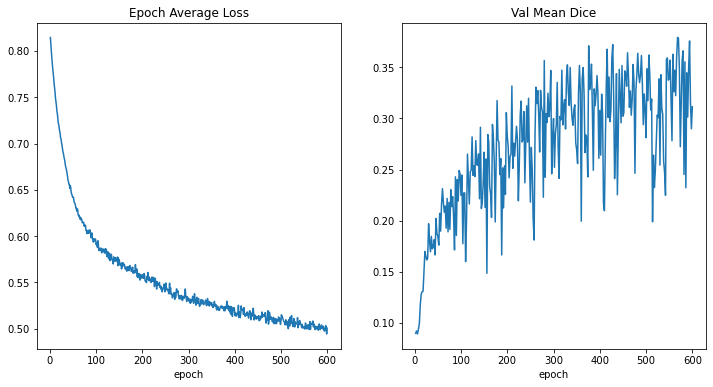

In [27]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

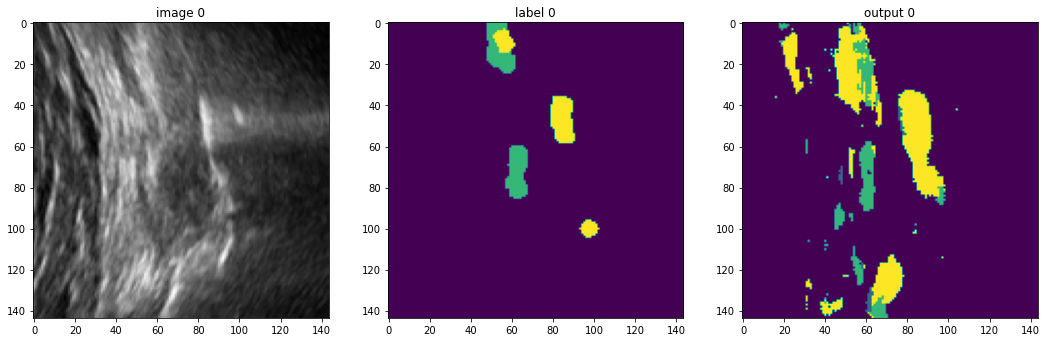

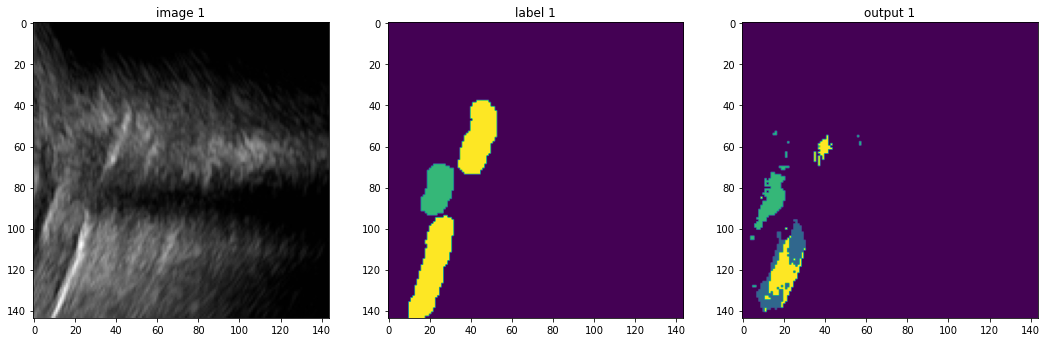

In [28]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (144, 144, 16)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 10], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 10])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 10])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [40]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=True, num_classes=4),
    AsDiscreted(keys="label", to_onehot=True, num_classes=4),
])

In [41]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (144, 144, 16)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

torch.Size([4, 325, 320, 60]) torch.Size([4, 325, 320, 60])
torch.Size([4, 325, 320, 61]) torch.Size([4, 325, 320, 61])
torch.Size([4, 325, 320, 61]) torch.Size([4, 325, 320, 61])
torch.Size([4, 325, 320, 61]) torch.Size([4, 325, 320, 61])
torch.Size([4, 325, 320, 61]) torch.Size([4, 325, 320, 61])
torch.Size([4, 325, 320, 60]) torch.Size([4, 325, 320, 60])
Metric on original image spacing:  0.25567594170570374


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)